In [1]:
import numpy as np
import scipy as sc
import csv
import scipy.linalg as spl
import matplotlib.pyplot as plt
from opt_utils import *
from grad_utils import *
%matplotlib inline

# load data

In [2]:
data = np.load('simulation_data.npy')
latent = np.load('simulation_latent.npy')

# parameters

In [3]:
# # optimization parameters
# l_penalty = 1
# max_iter = 1000
# ths = 1e-12

# # vanilla PGD parameters
# step_size = 0.03

# # backtracking parameters
# step_init = 0.1
# max_back = 100
# a = 0.2
# b = 0.5

# L1 penalty

## Sub-gradient Descent

In [3]:
objective_gd, beta_gd = gd_l1(data = data)

initial objective value: 13028.394406
100-th GD, objective value: 10594.322645
200-th GD, objective value: 10594.253595
300-th GD, objective value: 10594.235349
400-th GD, objective value: 10594.227579
500-th GD, objective value: 10594.219918
600-th GD, objective value: 10594.216453
700-th GD, objective value: 10594.215399
800-th GD, objective value: 10594.213841
900-th GD, objective value: 10594.213530
1000-th GD, objective value: 10594.210447
1100-th GD, objective value: 10594.209473
1200-th GD, objective value: 10594.209376
1300-th GD, objective value: 10594.208962
1400-th GD, objective value: 10594.207754
1500-th GD, objective value: 10594.207247
1600-th GD, objective value: 10594.206313
1700-th GD, objective value: 10594.206801
1800-th GD, objective value: 10594.205819
1900-th GD, objective value: 10594.206828
2000-th GD, objective value: 10594.205504
2100-th GD, objective value: 10594.205797
2200-th GD, objective value: 10594.205663
2300-th GD, objective value: 10594.204845
2400-

19900-th GD, objective value: 10594.198270
20000-th GD, objective value: 10594.198257
20100-th GD, objective value: 10594.198167
20200-th GD, objective value: 10594.198323
20300-th GD, objective value: 10594.198187
20400-th GD, objective value: 10594.198259
20500-th GD, objective value: 10594.198179
20600-th GD, objective value: 10594.198186
20700-th GD, objective value: 10594.198183
20800-th GD, objective value: 10594.198246
20900-th GD, objective value: 10594.198210
21000-th GD, objective value: 10594.198259
21100-th GD, objective value: 10594.198182
21200-th GD, objective value: 10594.198111
21300-th GD, objective value: 10594.198180
21400-th GD, objective value: 10594.198243
21500-th GD, objective value: 10594.198237
21600-th GD, objective value: 10594.198109
21700-th GD, objective value: 10594.198118
21800-th GD, objective value: 10594.198196
21900-th GD, objective value: 10594.198060
22000-th GD, objective value: 10594.198134
22100-th GD, objective value: 10594.198127
22200-th GD

39200-th GD, objective value: 10594.197390
39300-th GD, objective value: 10594.197301
39400-th GD, objective value: 10594.197297
39500-th GD, objective value: 10594.197349
39600-th GD, objective value: 10594.197359
39700-th GD, objective value: 10594.197309
39800-th GD, objective value: 10594.197365
39900-th GD, objective value: 10594.197388
40000-th GD, objective value: 10594.197327
40100-th GD, objective value: 10594.197421
40200-th GD, objective value: 10594.197320
40300-th GD, objective value: 10594.197324
40400-th GD, objective value: 10594.197294
40500-th GD, objective value: 10594.197304
40600-th GD, objective value: 10594.197332
40700-th GD, objective value: 10594.197368
40800-th GD, objective value: 10594.197349
40900-th GD, objective value: 10594.197350
41000-th GD, objective value: 10594.197304
41100-th GD, objective value: 10594.197323
41200-th GD, objective value: 10594.197300
41300-th GD, objective value: 10594.197268
41400-th GD, objective value: 10594.197276
41500-th GD

## ADMM

In [9]:
def admm_l1(data,l_penalty = 1,max_iter = 1000,ths = 1e-12,eta = 20,
    step_init = 0.05,max_back = 200,a = 0.01,b = 0.3):
    # intiialize optimization
    T, N = data.shape[0:2]

    # optimization parameters
    eta = eta
    step_size = 0.03
    paras = [step_size, ths, max_iter]

    A = np.zeros(((T - 1) * N, T * N))
    for i in range(N):
        for t in range(T-1):
            A[t * N + i, (t + 1) * N + i] = 1
            A[t * N + i, (t) * N + i] = -1

    betak = np.zeros((T * N,1))

    thetak = np.zeros(((T - 1) * N,1))
    muk = A @ betak - thetak

    # initialize record
    objective_admm_b_l1= [objective_l1(betak, data, l_penalty)]
    objective_admm = [model.neg_log_like(betak, data) + l_penalty * np.linalg.norm(thetak,1)]
    print("initial objective value: %f"%objective_admm_b_l1[-1])

    # iteration
    for i in range(max_iter):
        # compute gradient
        betak = admm_sub_beta(data,T,N,A,l_penalty,eta,betak,muk,thetak,paras)
        thetak = prox_l1(l_penalty / eta,A @ betak + muk / eta)
        muk = muk + eta * (A @ betak - thetak)
        # objective value
        objective_admm_b_l1.append(objective_l1(betak, data, l_penalty))
        objective_admm.append(model.neg_log_like(betak, data) + l_penalty * np.linalg.norm(thetak,1))
        
    #     print("%d-th ADMM, objective value: %f"%(i+1, objective_admm_b_l2[-1]))
    #     if abs(objective_admm_b_l1[-2] - objective_admm_b_l1[-1]) < ths:
    #         print("Converged!")
    #         break
        print("%d-th ADMM, objective value: %f"%(i+1, objective_admm[-1]))
        if objective_admm[-2] - objective_admm[-1] < ths:
            print("Converged!")
            break
            
    if i >= max_iter - 1:
        print("Not converged.")
    return objective_admm, objective_admm_b_l1, betak


In [10]:
objective_admm, objective_admm_b_l1, beta_admm = admm_l1(data = data)

initial objective value: 13028.394406
1-th ADMM, objective value: 10655.837412
2-th ADMM, objective value: 10622.975071
3-th ADMM, objective value: 10606.075076
4-th ADMM, objective value: 10600.018148
5-th ADMM, objective value: 10597.535515
6-th ADMM, objective value: 10596.335821
7-th ADMM, objective value: 10595.710855
8-th ADMM, objective value: 10595.358642
9-th ADMM, objective value: 10595.140206
10-th ADMM, objective value: 10594.993243
11-th ADMM, objective value: 10594.883092
12-th ADMM, objective value: 10594.801940
13-th ADMM, objective value: 10594.728110
14-th ADMM, objective value: 10594.671798
15-th ADMM, objective value: 10594.617706
16-th ADMM, objective value: 10594.571471
17-th ADMM, objective value: 10594.532001
18-th ADMM, objective value: 10594.497813
19-th ADMM, objective value: 10594.467754
20-th ADMM, objective value: 10594.441030
21-th ADMM, objective value: 10594.417087
22-th ADMM, objective value: 10594.396744
23-th ADMM, objective value: 10594.378271
24-th

c:\python\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


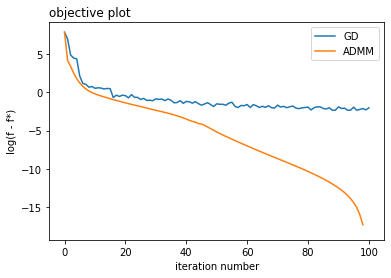

In [11]:
f = plt.figure(1, figsize = (6,4))
n_iter = len(objective_admm)

obj_opt = np.min([np.min(objective_gd), 
                  np.min(objective_admm)])
plt.plot(np.log(objective_gd - obj_opt)[:n_iter], label="GD")
plt.plot(np.log(objective_admm - obj_opt)[:n_iter], label="ADMM")

# obj_opt = np.min([np.min(objective_gd), 
#                   np.min(objective_admm_b_l1)])
# plt.plot(np.log(objective_gd - obj_opt)[:n_iter], label="GD")
# plt.plot(np.log(objective_admm_b_l1 - obj_opt)[:n_iter], label="ADMM")


plt.title("objective plot", loc='left')
plt.xlabel("iteration number")
plt.ylabel("log(f - f*)")
plt.legend()
f.savefig("converge_curve_l1.pdf", bbox_inches='tight')

c:\python\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


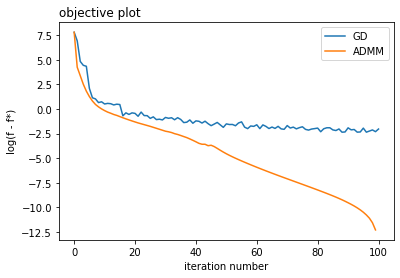

In [12]:
f = plt.figure(1, figsize = (6,4))
n_iter = len(objective_admm)

# obj_opt = np.min([np.min(objective_gd), 
#                   np.min(objective_admm)])
# plt.plot(np.log(objective_gd - obj_opt)[:n_iter], label="GD")
# plt.plot(np.log(objective_admm - obj_opt)[:n_iter], label="ADMM")

obj_opt = np.min([np.min(objective_gd), 
                  np.min(objective_admm_b_l1)])
plt.plot(np.log(objective_gd - obj_opt)[:n_iter], label="GD")
plt.plot(np.log(objective_admm_b_l1 - obj_opt)[:n_iter], label="ADMM")


plt.title("objective plot", loc='left')
plt.xlabel("iteration number")
plt.ylabel("log(f - f*)")
plt.legend()
f.savefig("converge_curve_l1.pdf", bbox_inches='tight')

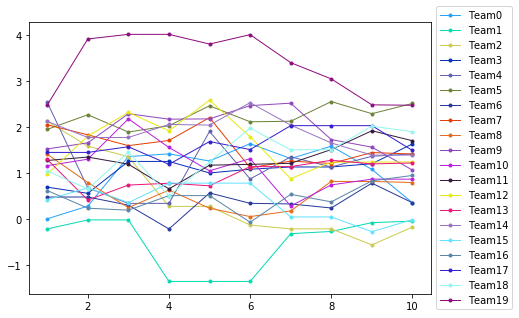

In [15]:
T, N = data.shape[0:2]
beta = beta_admm.reshape((T,N))
f = plt.figure(1, figsize = (9,5))
ax = plt.subplot(111)
for i in range(N):
    ax.plot(range(1,T + 1),beta[:,i],c=np.random.rand(3,),marker = '.',label = 'Team' + str(i),linewidth=1)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()
f.savefig("l1_solution.pdf", bbox_inches='tight')